In [596]:
from nltk.corpus import wordnet as wn
from fastai.basics import *
import nmslib
import pdb
from collections import defaultdict
from sklearn.metrics import average_precision_score
from fastprogress import master_bar, progress_bar
from multiprocessing import Process
import matplotlib.pyplot as plt
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [ ]:
next(wn.all_synsets(pos='n'))

In [727]:
d = wn.synset("mammal.n.01")

In [586]:
d.instance_hypernyms()

[]

In [698]:
computers = {x.name() for x in wn.synset("computer.n.01").closure(lambda s: s.hyponyms())}
computers.add("computer.n.01")

In [913]:
edges = set()
queue = [(wn.synset("mammal.n.01"),0)]
node_strength = defaultdict(int)
levels = {}
while queue:
    n,level = queue.pop(0)
    levels[n.name()] = level
    nh = 0
    for hypo in n.closure(lambda s: s.hyponyms()):
        edges.add((hypo.name(),n.name()))
        queue.append((hypo,level+1))
        nh += 1
    node_strength[n.name()] = nh

In [914]:
dedges = set()
queue = [(wn.synset("mammal.n.01"),0)]
node_strength = defaultdict(int)
levels = {}
while queue:
    n,level = queue.pop(0)
    levels[n.name()] = level
    nh = 0
    for hypo in n.hyponyms():
        dedges.add((hypo.name(),n.name()))
        queue.append((hypo,level+1))
        nh += 1
    node_strength[n.name()] = nh

In [410]:
edges = set()
for synset in wn.all_synsets(pos='n'):
    # write the transitive closure of all hypernyms of a synset to file
    for hyper in synset.closure(lambda s: s.hypernyms()):
        edges.add((synset.name(), hyper.name()))

    # also write transitive closure for all instances of a synset
    for instance in synset.instance_hyponyms():
        for hyper in instance.closure(lambda s: s.instance_hypernyms()):
            edges.add((instance.name(), hyper.name()))
            for h in hyper.closure(lambda s: s.hypernyms()):
                edges.add((instance.name(), h.name()))

#edges                
# with open(f'noun_closure.tsv', 'w') as fout:
#     for i, j in edges:
#         fout.write(f'{i}\t{j}\n')


In [313]:
eps = 1e-5
boundary = 1 - eps
class PoincareDistance(torch.autograd.Function):

    @staticmethod
    def grad(x, v, sqnormx, sqnormv, sqdist):
        alpha = (1 - sqnormx)
        beta = (1 - sqnormv)
        z = 1 + 2 * sqdist / (alpha * beta)
        a = ((sqnormv - 2 * torch.sum(x * v, dim=-1) + 1) / torch.pow(alpha, 2))
        a = a.unsqueeze(-1) * x - v / alpha.unsqueeze(-1)
        z = torch.sqrt(torch.pow(z, 2) - 1)
        z = torch.clamp(z * beta, min=eps)
        return 4 * a / z.unsqueeze(-1)
    
    @staticmethod
    def forward(self, u, v):
        self.save_for_backward(u, v)
        self.squnorm = torch.clamp(torch.sum(u * u, dim=-1), 0, boundary)
        self.sqvnorm = torch.clamp(torch.sum(v * v, dim=-1), 0, boundary)
        self.sqdist = torch.sum(torch.pow(u - v, 2), dim=-1)
        x = self.sqdist / ((1 - self.squnorm) * (1 - self.sqvnorm)) * 2 + 1
        # arcosh
        z = torch.sqrt(torch.pow(x, 2) - 1)
        return torch.log(x + z)
    
    @staticmethod
    def backward(self, g):
        u, v = self.saved_tensors
        g = g.unsqueeze(-1)
        gu = PoincareDistance.grad(u, v, self.squnorm, self.sqvnorm, self.sqdist)
        gv = PoincareDistance.grad(v, u, self.sqvnorm, self.squnorm, self.sqdist)
        return g.expand_as(gu) * gu, g.expand_as(gv) * gv

In [302]:
def poincare_distance(u,v):
    squnorm = torch.clamp(torch.sum(u * u, dim=-1), 0, boundary)
    sqvnorm = torch.clamp(torch.sum(v * v, dim=-1), 0, boundary)
    sqdist = torch.sum(torch.pow(u - v, 2), dim=-1)
    x = sqdist / ((1 - squnorm) * (1 - sqvnorm)) * 2 + 1
    z = torch.sqrt(torch.pow(x, 2) - 1)
    return torch.log(x + z)

In [252]:
def euclidean_distance(u,v):
    return torch.sum((u-v)**2,dim=-1)

In [915]:
vocab = list({n for edge in edges for n in edge})
stoi = {s:i for i,s in enumerate(vocab)}
adj = defaultdict(set)
for a,b in edges: adj[stoi[a]].add(stoi[b])

In [916]:
negs = {}
for w in vocab:
    negs[w] = [stoi[x] for x in vocab if (w,x) not in edges]

In [880]:
class WNDataset(Dataset):
    def __init__(self,edges,vocab,negs):
        self.edges = edges
        self.vocab = vocab
        self.negs = negs
        self.items = [1,2,3]
        
    def __len__(self): return len(self.edges)
    
    def __getitem__(self,idx):
        a,b = self.edges[idx]
        #neg = torch.randint(0,len(vocab),(11,))
        #neg[0] = stoi[b]
        neg = np.zeros(11,dtype=np.int)
        neg[0] = stoi[b]
        neg[1:] = np.random.choice(self.negs[a],10,replace=False)
        return (stoi[a],neg),0

In [917]:
wnDS = WNDataset(list(edges),vocab,negs)
valDS = WNDataset(list(edges)[:100],vocab,negs)

In [918]:
db = DataBunch.create(wnDS,valDS,bs=32,num_workers=0)

In [7]:
class SimpleWN(torch.nn.Module):
    def __init__(self,vocabSize,embSize):
        super().__init__()
        self.emb = torch.nn.Embedding(vocabSize,embSize,sparse=True,max_norm=1.0)
        with torch.no_grad(): trunc_normal_(self.emb.weight, std=0.01)
        
    def forward(self,w,v):
        #pdb.set_trace()
        w = self.emb(w)
        v = self.emb(v.long())
        d = (w.unsqueeze(1)-v)**2
        return -d.sum(dim=2)

In [ ]:
def poincare_grad(p, d_p):
    r"""
    Function to compute Riemannian gradient from the
    Euclidean gradient in the Poincaré ball.

    Args:
        p (Tensor): Current point in the ball
        d_p (Tensor): Euclidean gradient at p
    """
    if d_p.is_sparse:
        p_sqnorm = th.sum(
            p.data[d_p._indices()[0].squeeze()] ** 2, dim=1,
            keepdim=True
        ).expand_as(d_p._values())
        n_vals = d_p._values() * ((1 - p_sqnorm) ** 2) / 4
        d_p = spten_t(d_p._indices(), n_vals, d_p.size())
    else:
        p_sqnorm = th.sum(p.data ** 2, dim=-1, keepdim=True)
        d_p = d_p * ((1 - p_sqnorm) ** 2 / 4).expand_as(d_p)
    return d_p

In [534]:
class EuclideanEmbedding(torch.nn.Module):
    def __init__(self,embSize,embDim):
        super().__init__()
        self.emb = torch.nn.Embedding(embSize,embDim,sparse=True,max_norm=1.0)
        with torch.no_grad(): trunc_normal_(self.emb.weight, std=0.01)
            
    def forward(self,x):
        return self.emb(x)

In [1076]:
class PoincareEmbedding(torch.nn.Module):
    def __init__(self,embSize,embDim):
        super().__init__()
        self.emb = torch.nn.Embedding(embSize,embDim,sparse=True,max_norm=1.0)
        def poincareGrad(d_p):
            p = self.emb.weight
            p_sqnorm = torch.sum(
                p.data[d_p._indices()[0].squeeze()] ** 2, dim=1,
                keepdim=True
            ).expand_as(d_p._values())
            n_vals = d_p._values() * ((1 - p_sqnorm) ** 2) / 4
            d_p = torch.sparse.FloatTensor(d_p._indices(), n_vals, d_p.size())
            return d_p
        self.emb.weight.register_hook(poincareGrad)
        
        #with torch.no_grad(): trunc_normal_(self.emb.weight, std=0.01)
        with torch.no_grad(): self.emb.weight.uniform_(-0.001,0.001)
        
    def forward(self,x):
        return self.emb(x)

In [1077]:
#dist_fn = poincare_distance
dist_fn = PoincareDistance.apply
#dist_fn = euclidean_distance
class PoincareWN(torch.nn.Module):
    def __init__(self,vocabSize,embSize):
        super().__init__()
        self.emb = PoincareEmbedding(vocabSize,embSize)
        #self.emb = EuclideanEmbedding(vocabSize,embSize)
        
    def forward(self,w,v):
        w = self.emb(w)
        v = self.emb(v.long())
        d = dist_fn(w.unsqueeze(1),v)
        return -d

In [1078]:
class MapMetric(Callback):
    def on_epoch_end(self, **kwargs):
        self.metric = mean_average_precision(adj.items(),learn.model.emb.emb.weight,pb=False)

In [1090]:
model = PoincareWN(len(vocab),2)

In [1091]:
learn = Learner(db,model,loss_func=torch.nn.functional.cross_entropy,opt_func=torch.optim.SparseAdam,metrics=[MapMetric()])

In [1092]:
x,y = next(iter(db.train_dl))
model(*x).size()

torch.Size([32, 11])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


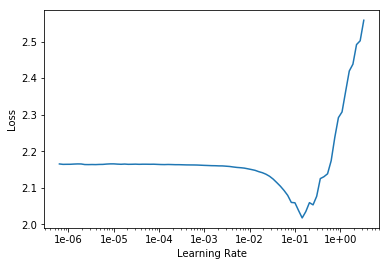

In [1054]:
learn.lr_find(num_it=100)
learn.recorder.plot()

In [1107]:
#learn.fit_one_cycle(10,1e-4,wd=0)
learn.fit(10,1e-3,wd=0)

epoch,train_loss,valid_loss,map_metric
1,0.556874,0.353096,0.375411
2,0.568604,0.419632,0.361980
3,0.529404,0.593894,0.351846
4,0.570418,0.601531,0.354193
5,0.616821,0.516940,0.338568
6,0.581814,0.358838,0.336291
7,0.547261,0.288989,0.342507
8,0.569204,0.583869,0.346156
9,0.555470,0.644104,0.352355
10,0.571408,0.501892,0.343864


In [940]:
learn.save("t")

In [834]:
def precision_recall():
    emb = learn.model.emb.emb
    thresh = 5
    accuracy = []
    precision = []
    recall = []
    with torch.no_grad():
        for n,na in progress_bar(adj.items()):
            dists = dist_fn(emb.weight[n].unsqueeze(0),emb.weight)
            dists[n] = 1e12
            labels = torch.zeros(emb.weight.size(0)).cuda()
            labels[list(na)] = 1
            tp = ((dists <= thresh) & (labels == 1)).sum().item()
            fp = ((dists <= thresh) & (labels == 0)).sum().item()
            fn = ((dists > thresh) & (labels == 1)).sum().item()
            tn = ((dists > thresh) & (labels == 0)).sum().item()
            accuracy.append((tp + tn) / len(adj))
            precision.append(tp / (tp + fp) if (tp + fp) > 0 else 1.0)
            recall.append(tp / (tp + fn))  
    return np.mean(accuracy), np.mean(precision), np.mean(recall)

In [835]:
precision_recall()

(0.9915612987638313, 0.8494175273261461, 0.1753615218542507)

In [1008]:
def mean_average_precision(adj,emb,pb=True):
    ap = []
    with torch.no_grad():
        a = adj
        if pb: a = progress_bar(a)
        for n,na in a:
            dists = dist_fn(emb[n].unsqueeze(0),emb)
            dists[n] = 1e12
            dists = dists.cpu().numpy()
            labels = np.zeros(emb.size(0))
            labels[list(na)] = 1
            ap.append(average_precision_score(labels,-dists))
    return np.mean(ap)

In [1009]:
mean_average_precision(adj.items(),learn.model.emb.emb.weight)

0.6950692037468472

AxesSubplot(0.125,0.125;0.775x0.755)


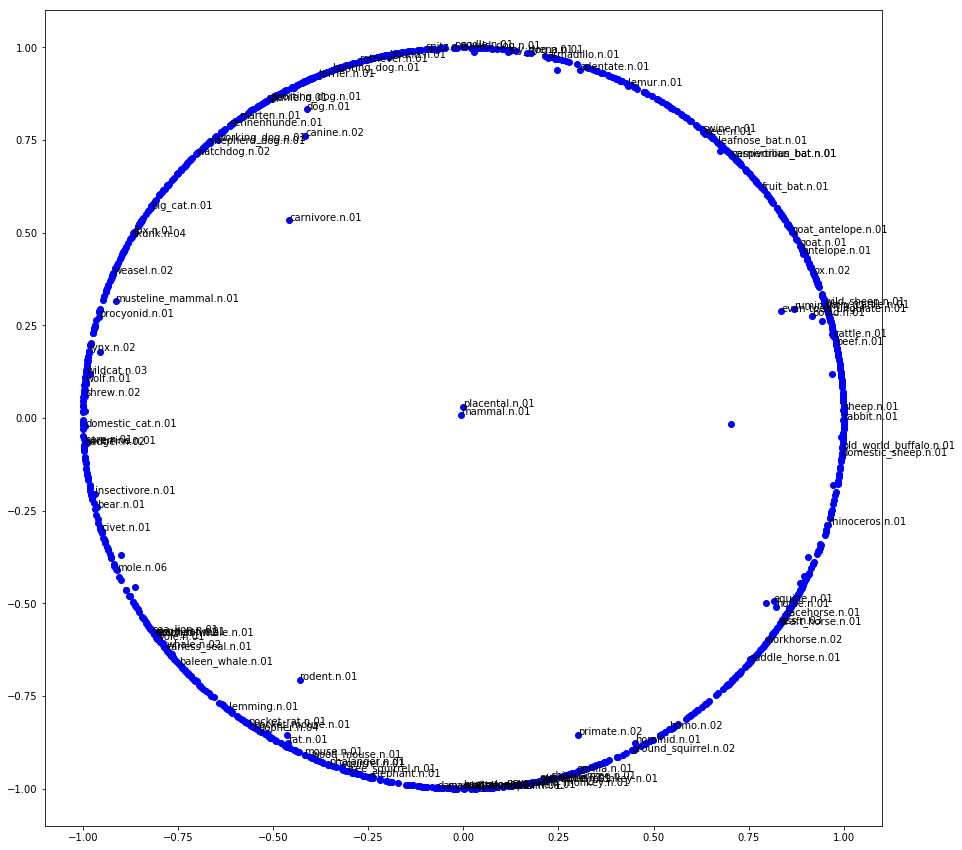

In [1108]:
weights = learn.model.emb.emb.weight.cpu().detach().numpy()
#weights = gsemb
fig,ax = plt.subplots(figsize=(15,15))
print(ax)
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
for i,(x,y) in enumerate(weights):
    ax.plot(x,y,marker="o",color="blue")
    if node_strength[vocab[i]] > 3:
    #if levels[vocab[i]] < 3:
        ax.annotate(vocab[i],(x,y))
# for a,b in dedges:
#     x1,y1 = weights[stoi[a]]
#     x2,y2 = weights[stoi[b]]
#     ax.plot([x1,x2],[y1,y2],color=(0,0,1,0.1))

In [1086]:
dists = dist_fn(torch.zeros(1,learn.model.emb.emb.weight.size()[1],dtype=torch.float).cuda(),learn.model.emb.emb.weight)
[vocab[i] for i in dists.argsort()[:10]]

['placental.n.01',
 'mammal.n.01',
 'carnivore.n.01',
 'ungulate.n.01',
 'rodent.n.01',
 'canine.n.02',
 'primate.n.02',
 'even-toed_ungulate.n.01',
 'dog.n.01',
 'ruminant.n.01']

In [1087]:
def knn(i,k,emb):
    dists = dist_fn(emb[i].unsqueeze(0),emb)
    return dists.argsort()[:k]

In [1088]:
for i in knn(stoi["silverback.n.01"],8,learn.model.emb.emb.weight): print(vocab[i])

silverback.n.01
gorilla.n.01
anthropoid_ape.n.01
ape.n.01
great_ape.n.01
chimpanzee.n.01
western_lowland_gorilla.n.01
pygmy_chimpanzee.n.01


In [1089]:
for j in np.random.choice(len(vocab),5,replace=False):
    for i in knn(j,8,learn.model.emb.emb.weight): print(vocab[i])
    print("")

papillon.n.01
canine.n.02
dog.n.01
carnivore.n.01
hunting_dog.n.01
mammal.n.01
placental.n.01
working_dog.n.01

cynopterus_sphinx.n.01
placental.n.01
mammal.n.01
ungulate.n.01
rodent.n.01
carnivore.n.01
even-toed_ungulate.n.01
bat.n.01

american_harvest_mouse.n.01
new_world_mouse.n.01
rodent.n.01
mammal.n.01
placental.n.01
carnivore.n.01
ungulate.n.01
canine.n.02

starnose_mole.n.01
mammal.n.01
placental.n.01
carnivore.n.01
rodent.n.01
ungulate.n.01
canine.n.02
primate.n.02

tiger_cat.n.01
feline.n.01
cat.n.01
wildcat.n.03
domestic_cat.n.01
mammal.n.01
placental.n.01
carnivore.n.01



In [337]:
weights = learn.model.emb.weight.cpu().detach().numpy()

In [341]:
index = nmslib.init(space="angulardist")
#index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(weights)
nms = index.createIndex()

In [344]:
index.knnQuery(weights[0],k=8)

(array([    0, 14275, 49537, 15023,  5083,  2371, 68748, 53884], dtype=int32),
 array([3.452670e-04, 1.147919e+00, 1.175898e+00, 1.177698e+00, 1.192523e+00, 1.196113e+00, 1.203330e+00, 1.204221e+00],
       dtype=float32))

In [345]:
for j in np.random.choice(len(weights),10,replace=False):
    for i,v in zip(*index.knnQuery(weights[j],k=8)): print(vocab[i],v)
    print("")

pancreatic_artery.n.01 0.0
ricochet.n.01 1.0741749
cabaret.n.01 1.0790951
hawaiian.n.01 1.146588
gluteal_artery.n.01 1.1700519
distribution_law.n.01 1.1712523
supper_club.n.01 1.1785396
leptomeninges.n.01 1.1858814

shade.n.03 0.0
dithyramb.n.01 1.1487309
akan.n.01 1.1652424
jerry-builder.n.01 1.1711454
libyan_islamic_fighting_group.n.01 1.184254
bruckenthalia.n.01 1.1843824
reproductive_cell.n.01 1.1909854
retrospect.n.01 1.1953257

infection.n.06 0.0
sturdiness.n.02 1.1472279
paramount_issue.n.01 1.1777446
paye.n.01 1.1780039
rhinolophidae.n.01 1.1917481
psalterium.n.01 1.2004938
thermograph.n.02 1.2016636
loch.n.01 1.2042066

huarache.n.01 0.0
portuguese_man-of-war.n.01 1.1645626
terminal.n.02 1.1754081
cassia.n.03 1.1754664
virgil.n.01 1.191882
principle_of_superposition.n.01 1.2011315
luminism.n.01 1.2073865
bede.n.01 1.2134898

pan_american_union.n.01 1.1998929
midbrain.n.01 1.2295023
jointer.n.01 1.2427332
fracture.n.03 1.2476367
brush_cut.n.01 1.248769
thermoreceptor.n.01 1.253

In [896]:
from gensim.models.poincare import PoincareModel, ReconstructionEvaluation
from gensim.viz.poincare import poincare_2d_visualization
import plotly

In [961]:
gmodel = PoincareModel(list(edges),size=200)

In [962]:
gmodel.train(epochs=50)

In [975]:
gmodel.kv.most_similar("mastiff.n.01")

[('working_dog.n.01', 3.939382570409183),
 ('tibetan_mastiff.n.01', 4.263795513072967),
 ('canine.n.02', 4.724628062837136),
 ('dog.n.01', 4.729202192381526),
 ('carnivore.n.01', 4.951776036130698),
 ('mammal.n.01', 5.5802802890389),
 ('placental.n.01', 5.647726918912133),
 ('shepherd_dog.n.01', 5.9406894231817855),
 ('watchdog.n.02', 6.056798588364519),
 ('boxer.n.04', 6.082075341507639)]

In [974]:
for j in np.random.choice(len(gmodel.kv.vectors),5,replace=False):
    for k,d in gmodel.kv.most_similar(gmodel.kv.vectors[j]): print(k,d)
    print("")

giant_schnauzer.n.01 0.0
terrier.n.01 4.610287877418391
canine.n.02 4.9184804700695475
dog.n.01 4.947982922729218
hunting_dog.n.01 5.1543031144265585
schnauzer.n.01 5.191072739055557
carnivore.n.01 5.407088709087248
mammal.n.01 6.12960155054821
placental.n.01 6.182192811706178
hound.n.01 6.356507788510994

tibetan_mastiff.n.01 0.0
mastiff.n.01 4.263795513072949
working_dog.n.01 4.523043038435711
dog.n.01 5.0951190659490155
canine.n.02 5.0996321965135065
carnivore.n.01 5.272275709904405
mammal.n.01 5.870984734676398
placental.n.01 5.938110177139585
sennenhunde.n.01 6.385130097033777
shepherd_dog.n.01 6.457660486358431

whippet.n.01 0.0
greyhound.n.01 4.696719958238026
canine.n.02 5.109817612074757
dog.n.01 5.1268975356789035
hunting_dog.n.01 5.133232798180536
hound.n.01 5.567450481165795
carnivore.n.01 5.567546000619401
italian_greyhound.n.01 5.921775737276181
mammal.n.01 6.326397388384503
placental.n.01 6.368349830630328

silverback.n.01 0.0
great_ape.n.01 1.999968082423192
ape.n.01 2.

In [964]:
gsemb = []
for w in vocab: gsemb.append(gmodel.kv.get_vector(w))
gsemb = np.stack(gsemb)

In [965]:
mean_average_precision(adj.items(),torch.tensor(gsemb).cuda())

0.668793930682269

In [902]:
a = gmodel.kv.vocab["bovid.n.01"]
a.index

246

In [966]:
ap = []
for n,na in progress_bar(adj.items()):
    dists = gmodel.kv.distances(vocab[n])
    dists[gmodel.kv.vocab[vocab[n]].index] = 1e12
    labels = np.zeros(len(dists))
    na = [gmodel.kv.vocab[vocab[x]].index for x in na]
    labels[list(na)] = 1
    ap.append(average_precision_score(labels,-dists))
np.mean(ap)

0.668793930682269

In [967]:
with open("out.tsv","w") as f:
    for a,b in edges:
        f.write(f"{a}\t{b}\n")

In [968]:
re = ReconstructionEvaluation("out.tsv",gmodel.kv)

In [969]:
re.evaluate()

{'mean_rank': 6.127171215880893, 'MAP': 0.49424245811051254}

In [907]:
import plotly.graph_objs as go

In [908]:
def Npoincare_2d_visualization(model, tree, figure_title, num_nodes=50, show_node_labels=()):
    """Create a 2-d plot of the nodes and edges of a 2-d poincare embedding.

    Parameters
    ----------
    model : :class:`~gensim.models.poincare.PoincareModel`
        The model to visualize, model size must be 2.
    tree : set
        Set of tuples containing the direct edges present in the original dataset.
    figure_title : str
        Title of the plotted figure.
    num_nodes : int or None
        Number of nodes for which edges are to be plotted.
        If `None`, all edges are plotted.
        Helpful to limit this in case the data is too large to avoid a messy plot.
    show_node_labels : iterable
        Iterable of nodes for which to show labels by default.

    Returns
    -------
    :class:`plotly.graph_objs.Figure`
        Plotly figure that contains plot.

    """
    vectors = model.kv.syn0
    if vectors.shape[1] != 2:
        raise ValueError('Can only plot 2-D vectors')

    node_labels = model.kv.index2word
    nodes_x = list(vectors[:, 0])
    nodes_y = list(vectors[:, 1])
    nodes = go.Scatter(
        x=nodes_x, y=nodes_y,
        mode='markers',
        marker=dict(color='rgb(30, 100, 200)'),
        text=node_labels,
        textposition='bottom center'
    )

    nodes_x, nodes_y, node_labels = [], [], []
    for node in show_node_labels:
        vector = model.kv[node]
        nodes_x.append(vector[0])
        nodes_y.append(vector[1])
        node_labels.append(node)
    nodes_with_labels = go.Scatter(
        x=nodes_x, y=nodes_y,
        mode='markers+text',
        marker=dict(color='rgb(200, 100, 200)'),
        text=node_labels,
        textposition='bottom center'
    )

    node_out_degrees = Counter(hypernym_pair[1] for hypernym_pair in tree)
    if num_nodes is None:
        chosen_nodes = list(node_out_degrees.keys())
    else:
        chosen_nodes = list(sorted(node_out_degrees.keys(), key=lambda k: -node_out_degrees[k]))[:num_nodes]

    edges_x = []
    edges_y = []
    for u, v in tree:
        if not(u in chosen_nodes or v in chosen_nodes):
            continue
        vector_u = model.kv[u]
        vector_v = model.kv[v]
        edges_x += [vector_u[0], vector_v[0], None]
        edges_y += [vector_u[1], vector_v[1], None]
    edges = go.Scatter(
        x=edges_x, y=edges_y, mode="lines", hoverinfo="none",
        line=dict(color='rgb(50,50,50)', width=1))

    layout = go.Layout(
        title=figure_title, showlegend=False, hovermode='closest', width=800, height=800)
    return go.Figure(data=[edges, nodes, nodes_with_labels], layout=layout)

In [909]:
plotly.offline.init_notebook_mode(connected=True)

In [911]:
plotly.offline.iplot(Npoincare_2d_visualization(gmodel,edges,"Mammals"))